<a href="https://colab.research.google.com/github/Anshuman33/face-attendance/blob/main/Face%20Recognition%20Using%20Siamese%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [4]:
import os
import numpy as np
import PIL as pil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Flatten,Input,Dense,Lambda,Dropout,MaxPool2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

# Loading the dataset

#### 1. Use `ImageDataGenerator` to load class-wise images

In [5]:
DATAPATH = "/content/drive/MyDrive/AI Project/cropped_images"

In [67]:
# Get the cropped face images dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(DATAPATH,
                                              target_size=(128, 128),
                                              subset="training")
val_generator = train_datagen.flow_from_directory(DATAPATH,
                                              target_size=(128, 128),
                                              subset="validation")

Found 65 images belonging to 5 classes.
Found 14 images belonging to 5 classes.


#### 2. Load the images into a numpy array along with their labels 

In [68]:
def datagen_to_np_array(generator):
    images, labels = [], []
    generator.reset()
    for i in range(len(generator)):
        batch_X, batch_Y = generator.next()
        images.append(batch_X)
        labels.append(batch_Y)
    images = np.concatenate(images, axis = 0)
    labels = np.concatenate(labels, axis = 0)
    labels = np.argmax(labels, axis = 1)
    return images, labels

In [69]:
train_images, train_labels = datagen_to_np_array(train_generator)
val_images, val_labels = datagen_to_np_array(val_generator)

In [70]:
print("Train images array shape: ", train_images.shape)
print("Val images array shape: ", val_images.shape)
print("Train labels array shape: ", train_labels.shape)
print("Val labels array shape: ", val_labels.shape)

Train images array shape:  (65, 128, 128, 3)
Val images array shape:  (14, 128, 128, 3)
Train labels array shape:  (65,)
Val labels array shape:  (14,)


# Creating pairs of images

Create pairs of images and assign label to each pair such that pair of similar images get label 1 and dissimilar pair gets a label 0.

In [71]:
def create_pairs_from_dataset(images, labels):
    '''
        Creates similar and dissimilar pairs of images from image and label set.
    '''
    # Find the indices belonging to each class
    label_indices = [np.where(labels == i)[0] for i in range(5)]

    # Get pairs of images and corresponding similarity label
    pairs, y = create_pairs(images, label_indices)
    y = y.astype('float32')
    return pairs, y

def create_pairs(images, label_indices):
    '''Positive and negative pair creation. Alternates between positive and
    negative pairs'''
    pairs = []
    similarity_labels = []
    
    n = min([len(label_index) for label_index in label_indices]) - 1
    
    for class_index in range(5):
        for i in range(n):
            # Gets indices for same class images and add similar pairs to pairs list
            z1, z2 = label_indices[class_index][i], label_indices[class_index][i+1]
            pairs.append([images[z1], images[z2]])

            # Gets indices for different class images and add dissimilar pair to pairs list
            inc = np.random.randint(1, 5)
            diff_class_index = (class_index + inc) % 5
            z1, z2 = label_indices[class_index][i], label_indices[diff_class_index][i]
            pairs.append([images[z1], images[z2]])

            # Adds labels for above two pairs
            similarity_labels += [1, 0]

    return np.array(pairs), np.array(similarity_labels)

In [72]:
train_pairs, train_ys = create_pairs_from_dataset(train_images, train_labels)
val_pairs, val_ys = create_pairs_from_dataset(val_images, val_labels)

In [73]:
print("Train pairs shape: ", train_pairs.shape)
print("Val pairs shape: ", val_pairs.shape)
print("Train ys shape: ", train_ys.shape)
print("Val ys shape: ", val_ys.shape)

Train pairs shape:  (80, 2, 128, 128, 3)
Val pairs shape:  (10, 2, 128, 128, 3)
Train ys shape:  (80,)
Val ys shape:  (10,)


# Visualize pairs of images

In [74]:
# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

# Utility to display a row of pairs with their true labels/predictions
def visualize_pairs(left, right, labels, predictions=None, title = None, n=10):
    plt.figure(figsize=(17,3))
    if title:
        plt.title(title)
        
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 128, 128, 3])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [128, 128*n, 3])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])

    if predictions is not None:
        plt.xticks([128*x+64 for x in range(n)], predictions)
        for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
            if predictions[i] > 0.5: t.set_color('red') # far predictions in red
    else:
        plt.xticks([128*x+64 for x in range(n)], labels)
        
    plt.grid(None)
    right = np.reshape(right, [n, 128, 128,3])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [128, 128*n, 3])
    plt.imshow(right)

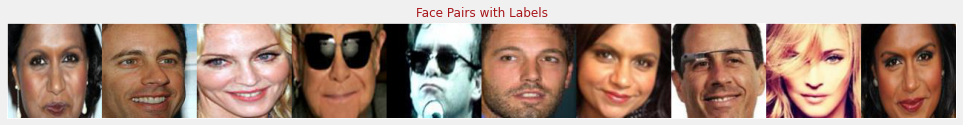

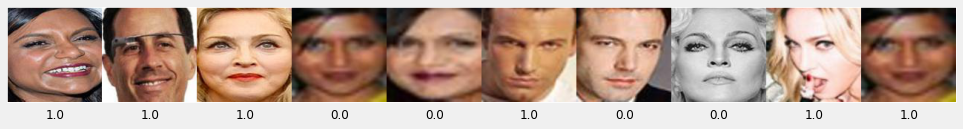

In [75]:
pair_indices = np.random.choice(len(train_pairs), 10, replace=False)
visualize_pairs(train_pairs[pair_indices, 0],
                train_pairs[pair_indices, 1], 
                train_ys[pair_indices], 
                title="Face Pairs with Labels", n = 10)

**We can observe that pairs with same images have label 1 and dissimilar images have label 0.** 

# Building the Siamese Network

#### 1. Building Base Network 

In [147]:
# Method to create the Base network
def build_base_network():
    input = Input(shape=(128, 128, 3), name="base_input")
    x = Conv2D(32, (3, 3), activation="relu", name="conv1")(input)
    x = MaxPool2D(pool_size=(2,2), name="pool1")(x)
    # x = Conv2D(16, (3, 3), activation="relu", name="conv2")(x)
    # x = MaxPool2D(pool_size=(2,2), name="pool2")(x)
    x = Flatten(name="flatten_input")(x)
    x = Dense(units=128, activation='relu', name='base_first_dense')(x)
    x = Dropout(0.2, name="first_dropout")(x)
    x = Dense(units=64, name='base_second_dense')(x)
    return Model(inputs=input, outputs=x, name="base_network")

In [148]:
base_network = build_base_network()
base_network.summary()

Model: "base_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 126, 126, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 63, 63, 32)        0         
                                                                 
 flatten_input (Flatten)     (None, 127008)            0         
                                                                 
 base_first_dense (Dense)    (None, 128)               16257152  
                                                                 
 first_dropout (Dropout)     (None, 128)               0         
                                                                 
 base_second_dense (Dense)   (None, 64)               

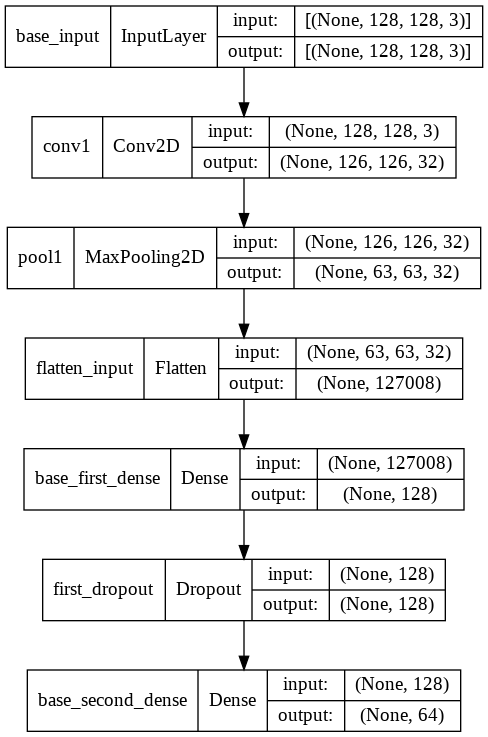

In [149]:
plot_model(base_network, show_shapes=True)

#### 2. Defining the euclidean distance function to compute distance between two vectors

In [150]:
# Function computes the euclidean distance between two vectors
def euclidean_distance(vectors):
    vec1, vec2 = vectors
    squared_sum = K.sum(K.square(vec1 - vec2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(squared_sum, K.epsilon()))

def eucl_dist_outshape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#### 3. Combine inputs, base network and output layer to create the siamese network 

In [184]:
# Creates the entire network
def build_siamese_network():
    base_network = build_base_network()

    input_a = Input(shape=(128, 128, 3), name="input_a")
    output_vector_a = base_network(input_a)

    input_b = Input(shape=(128, 128, 3), name="input_b")
    output_vector_b = base_network(input_b)

    output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_outshape)([output_vector_a, output_vector_b])

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model


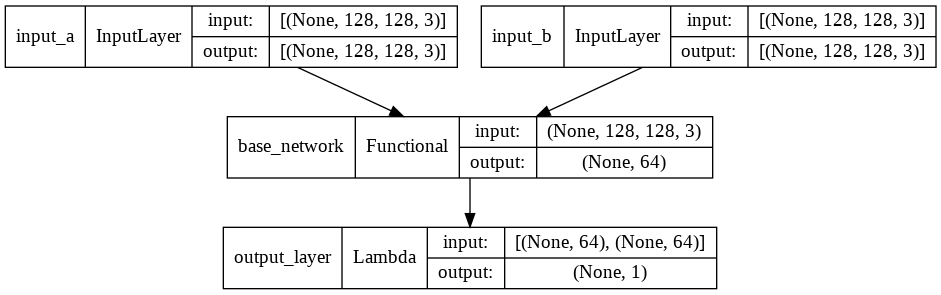

In [185]:
siamese_model = build_siamese_network()
plot_model(siamese_model, show_shapes=True)

# Creating the loss function

In [186]:
# Wrapper function to return the contastive loss function with margin
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        pred_square = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * pred_square + (1-y_true)*margin_square)
    return contrastive_loss 

# Training the Network

In [187]:
opt = tf.keras.optimizers.SGD(learning_rate=5e-4)
siamese_model.compile(loss=contrastive_loss_with_margin(margin=2.0), optimizer=opt)

In [188]:
history = siamese_model.fit([train_pairs[:, 0], train_pairs[:,1]], train_ys,
                    epochs=200, batch_size=8,
                    validation_data=([val_pairs[:,0], val_pairs[:,1]], val_ys))

Epoch 1/200
10/10 [==============================] - 1s 32ms/step - loss: 1.1594 - val_loss: 1.2580
Epoch 2/200
10/10 [==============================] - 0s 15ms/step - loss: 1.0598 - val_loss: 1.5722
Epoch 3/200
10/10 [==============================] - 0s 14ms/step - loss: 1.1265 - val_loss: 1.3672
Epoch 4/200
10/10 [==============================] - 0s 14ms/step - loss: 1.1285 - val_loss: 1.3178
Epoch 5/200
10/10 [==============================] - 0s 13ms/step - loss: 1.1461 - val_loss: 1.3835
Epoch 6/200
10/10 [==============================] - 0s 13ms/step - loss: 0.9621 - val_loss: 1.3702
Epoch 7/200
10/10 [==============================] - 0s 13ms/step - loss: 1.0769 - val_loss: 1.3447
Epoch 8/200
10/10 [==============================] - 0s 13ms/step - loss: 1.0364 - val_loss: 1.5216
Epoch 9/200
10/10 [==============================] - 0s 14ms/step - loss: 0.8752 - val_loss: 1.3132
Epoch 10/200
10/10 [==============================] - 0s 13ms/step - loss: 0.8716 - val_loss: 1.2526

# Evaluating the model

In [111]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distance'''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [189]:
train_loss = siamese_model.evaluate(x=[train_pairs[:,0], train_pairs[:,1]], y = train_ys)
val_loss = siamese_model.evaluate(x=[val_pairs[:,0], val_pairs[:,1]], y = val_ys)
 
y_pred_train = siamese_model.predict([train_pairs[:, 0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_ys, y_pred_train)

y_pred_val = siamese_model.predict([val_pairs[:, 0], val_pairs[:,1]])
val_accuracy = compute_accuracy(val_ys, y_pred_val)

print("Training Loss = {} \tValidation Loss ={}".format(train_loss,val_loss))
print("Training Accuracy = {} \tValidation accuracy={}".format(train_accuracy, val_accuracy))

1/1 [==============================] - 0s 25ms/step - loss: 0.9167
Training Loss = 0.0990712121129036 	Validation Loss =0.9166597127914429
Training Accuracy = 1.0 	Validation accuracy=0.7


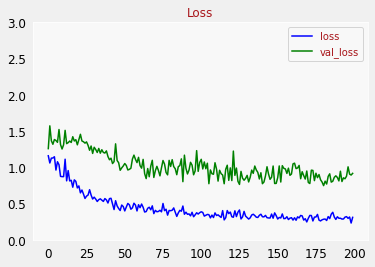

In [190]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_'+metric_name)
    plt.legend()

plot_metrics('loss', 'Loss', ylim=3)

**Validation loss flattens way earlier than training loss. Hence, overfitting is occuring.**

# Visualizing the results

## Run the model on training pairs to see its output

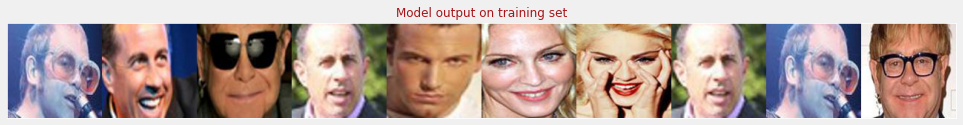

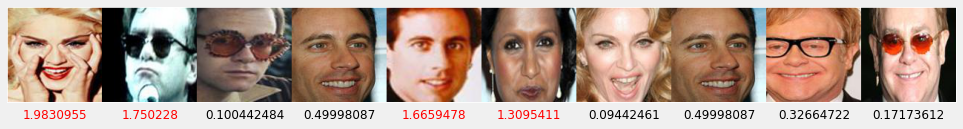

In [191]:
# Use the plotting utilities
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
visualize_pairs(train_pairs[:,0][indexes], train_pairs[:,1][indexes],train_ys[indexes], y_pred_train[indexes], "Model output on training set", 10)

## Run the model on validation pairs to see its output

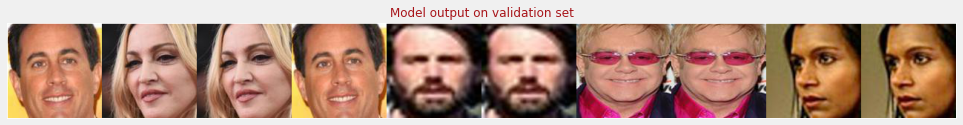

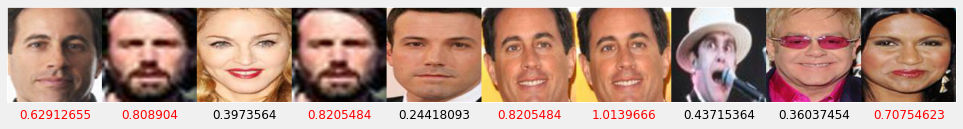

In [192]:
# Use the plotting utilities
y_pred_val = np.squeeze(y_pred_val)
indexes = np.random.choice(len(y_pred_val), size=10, replace=False)
visualize_pairs(val_pairs[:,0][indexes], val_pairs[:,1][indexes],val_ys[indexes], y_pred_val[indexes], "Model output on validation set", 10)

We can observe that our model is not performing that well on validation set. Hence, we need to add regularization to make the model overfit less.